In [1]:
import meshio
import pygalmesh
import pygmsh
import numpy as np
import copy
import glob
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *
import numba

# Initialisation

User settings: What are the continuum parameters we want? In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [2]:
# Target mesh size:
target_a = 0.2
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
#B=1000000
B=50000
# The Material Nonlinearity parameter, between 0 and 1
MatNon=0.0
khook = mu

Setting up the experiment:

In [3]:
# root folder for data
DataFolder=os.getcwd()+'/Data/Scratch/'
# Name of the current file
ScriptName="ElasticModuliiCalibration.ipynb"

In [4]:
try:
    os.mkdir(DataFolder)
except OSError:
    print ("Creation of the directory %s failed" % DataFolder)
else:
    print ("Successfully created the directory %s " % DataFolder)
    
# try and clear out the folder of vtk files and log files, if there was a previous run in it
for filename in glob.glob(DataFolder+'*.vtk')+glob.glob(DataFolder+'*.log'):
    file_path = os.path.join(DataFolder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
                
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a, 
        "B":B,
        "mu":mu,
        "alpha": MatNon
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/ failed


'/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/ElasticModuliiCalibration.ipynb'

# Making the Mesh

Make the mesh, write it out to the folder. I am going to use the gmsh mesh

In [5]:
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = target_a
    #geom.add_cylinder([0.0, 0.0, 0.0], 1)
    ellipsoid =geom.add_cylinder([0, 0.0, 0.0], [0.0, 0.0, 1], 1),
    #ellipsoid = geom.add_ellipsoid([0.0, 0.0, 0.0], [0.95, 0.95, 1.05])
    #ellipsoid =geom.add_box([-0.5,-0.5,-0.5],[1,1,1])
    InputMesh = geom.generate_mesh()

/home/jackbinysh/miniconda3/lib/python3.8/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


Make the bond lists, make the oriented boundary triangles list, make the mapping from bonds to boundary triangles

In [6]:
interiorbonds,edgebonds,boundarytris, bidxTotidx, tetras= MakeMeshData3D(InputMesh)
bonds=np.concatenate((interiorbonds,edgebonds))
orientedboundarytris=OrientTriangles(InputMesh.points,boundarytris,np.array([0,0,0]))
boundarytris=orientedboundarytris

Indices of the points on the toplayer and bottom layer

In [7]:
TopLayer= np.where((InputMesh.points[:,2]>0.99))[0]
BottomLayer= np.where((InputMesh.points[:,2]<0.01))[0]

Write a copy of the input Mesh, for visualisation

In [8]:
cells=[ ("line", bonds ), ("triangle",boundarytris ), ("tetra",tetras)]
isbond=  np.ones(len(bonds))
isedgebond= np.concatenate( ( np.zeros(len(interiorbonds)),np.ones(len(edgebonds)) ) )
CellDataDict={'isedgebond':[isedgebond,np.zeros(len(boundarytris)),np.zeros(len(tetras))]
              ,'isbond':[isbond,np.zeros(len(boundarytris)),np.zeros(len(tetras))]}

OutputMesh=meshio.Mesh(InputMesh.points, cells, {},CellDataDict)
OutputMesh.write(DataFolder+"InitialMesh.vtk",binary=True) 

0.24170323193529983

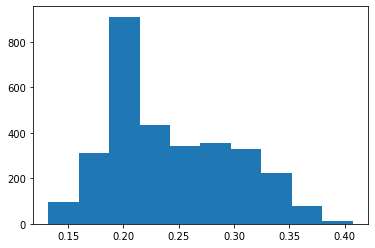

In [9]:
edgelengths= MakeBondHist(InputMesh.points,bonds)
np.mean(edgelengths)

# Energy Minimization

In [10]:
def mycallback(xi):
    
    counter=len(history)
    tempP = xi.reshape((-1, 3))
    history.append(counter)
        
    print("iteration:"+"{0:0.1f}".format(counter))   
    OutputMesh.points = tempP  
    Name="TempFz_"+"{0:0.3f}".format(E)+"_"+"{0:0d}".format(counter)+".vtk"
    
    CalibrationOutput3D(Name
                    ,DataFolder
                    ,OutputMesh
                    ,tempP
                    ,bonds
                    ,orientedboundarytris
                    ,tetras
                    ,r0_ij
                    ,khook
                    ,B
                    ,MatNon
                    ,TargetVolumes
                    ,TopLayer
                    ,topZavg
                    ,BottomLayer
                    ,bottomZavg
                    ,E)
 

In [11]:
# make the preferred rest lengths of the interior springs
interiorpairs=InputMesh.points[interiorbonds]
interiorvecs = np.subtract(interiorpairs[:,0,:],interiorpairs[:,1,:])
InteriorBondRestLengths=np.linalg.norm(interiorvecs,axis=1)

# make the preferred rest lengths of the edge springs. Initially have the at g0=1, but then
#update them in the loop
edgepairs=InputMesh.points[edgebonds]
edgevecs = np.subtract(edgepairs[:,0,:],edgepairs[:,1,:])
EdgeBondRestLengths=np.linalg.norm(edgevecs,axis=1)
  
r0_ij=np.concatenate((InteriorBondRestLengths,EdgeBondRestLengths))

# The volume constraint is simply that the target volume should be the initial volume
TargetVolumes=Volume3D_tetras(InputMesh.points,tetras)

for mode in ("Extension","Compression"):
    Pout_ij =InputMesh.points
    if mode=="Extension":
        Frange=np.arange(0,0.05,0.005)
    elif mode=="Compression":
        Frange=np.arange(0,-0.05,-0.005)
        
    for F in Frange:

        print("Current Fz"+"{0:0.3f}".format(F))
        
        # where are the current top and bottom surfaces, pre minimization? Use this for working out external work
        topZavg=zavg(Pout_ij,TopLayer)
        bottomZavg=zavg(Pout_ij,BottomLayer)
        print(topZavg)
        print(bottomZavg)

        # minimize
        history=[]

        #ModuliiEnergy(P,TopLayer,BottomLayer,bondlist,tetras,r0_ij,z0,khook,B,E,MatNon,TargetVolumes): 
        Pout_ij = opt.minimize(ModuliiEnergy, Pout_ij.ravel()
                               # ,callback=mycallback
                                ,options={'gtol':1e-03,'disp': True}  
                                ,args=(TopLayer
                                      ,BottomLayer
                                      ,bonds
                                      ,tetras
                                      ,r0_ij
                                      ,khook
                                      ,B
                                      ,F
                                      ,MatNon
                                      ,TargetVolumes)
                               ).x.reshape((-1, 3))


        Name="Fz_"+"{0:0.3f}".format(F)+".vtk"
        CalibrationOutput3D(Name
                            ,DataFolder
                            ,OutputMesh
                            ,Pout_ij
                            ,bonds
                            ,orientedboundarytris
                            ,tetras
                            ,r0_ij
                            ,khook
                            ,B
                            ,MatNon
                            ,TargetVolumes
                            ,TopLayer
                            ,BottomLayer
                            ,F)


Current Fz0.000
1.0
0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1708
         Gradient evaluations: 1
Current Fz0.005
1.0
0.0
Optimization terminated successfully.
         Current function value: -0.619512
         Iterations: 56
         Function evaluations: 99064
         Gradient evaluations: 58
Current Fz0.010
1.007328571435077
-0.007363556846366107
Optimization terminated successfully.
         Current function value: -1.248177
         Iterations: 71
         Function evaluations: 124684
         Gradient evaluations: 73
Current Fz0.015
1.0148492043942807
-0.014898747379929104
Optimization terminated successfully.
         Current function value: -1.886246
         Iterations: 159
         Function evaluations: 274988
         Gradient evaluations: 161
Current Fz0.020
1.0225320988907116
-0.022549454343394983
Optimization terminated successfully.
         Current function value: -2.5337

KeyboardInterrupt: 

# Analysis

In [12]:
import meshio
import os
import matplotlib.pyplot as plt
import numpy as np
from AnalysisFunctions import *
import glob
import re
from collections import namedtuple
from scipy.optimize import curve_fit

In [13]:
dataarray=np.loadtxt(DataFolder+"OutputSummary.log",skiprows=1)
dataarray=dataarray[dataarray[:,0].argsort()]
data=namedtuple('data','lam Volume TotalEnergy')
data.Volume=dataarray[:,1]
data.lam=dataarray[:,3]
data.TotalEnergy=dataarray[:,4]

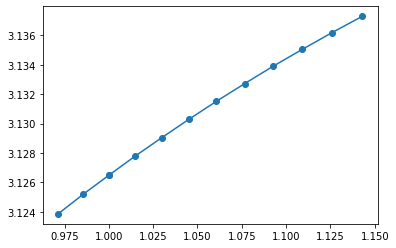

In [17]:
plt.plot(data.lam,data.Volume,marker='o')

Text(0.5, 1.0, 'Extension against energy per unit volume')

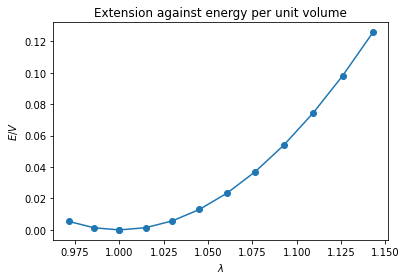

In [18]:
plt.plot(data.lam,data.TotalEnergy/data.Volume,marker='o')
plt.xlabel("$\lambda$")
plt.ylabel("$E/V$")
plt.title("Extension against energy per unit volume")

# Estimate shear modulus:

Expectation: $E = (\frac{3}{2} \mu \epsilon^2)V$, where $\epsilon=\lambda-1$

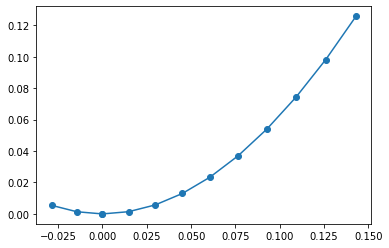

In [26]:
epsilon=(data.lam-1)[:]
EoverV=data.TotalEnergy[:]/data.Volume[:]
plt.plot(epsilon,EoverV,marker='o')

In [27]:
def func(epsilon,mu):
    return (3/2)*mu*(epsilon**2)

In [28]:
popt,pcov=curve_fit(func,epsilon,EoverV)

In [29]:
xFit=np.arange(-0.2,0.2,0.01)

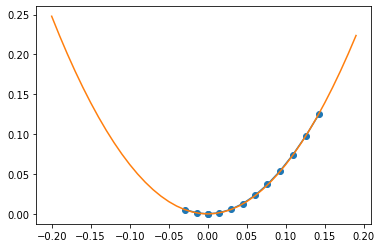

In [30]:
plt.plot(epsilon,EoverV,marker='o')
plt.plot(xFit,func(xFit,popt))

In [31]:
popt

array([4.13139548])

Conclusion: looks like the shear modulus here is $4.6$. A naive scaling argument suggests that $\mu = k_\mathrm{hook}/a$, where $a$ is the typical lattice size. Here, $k_{hook}=1$, $a=0.2$, so $\mu \approx 5$. So it does appear, indeed, that there is an $O(1)$ prefactor here.

# Get a NeoHookean Fit

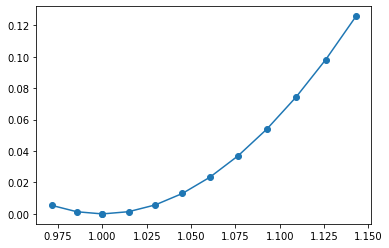

In [38]:
lam=data.lam
EoverV=data.TotalEnergy[:]/data.Volume[:]
plt.plot(lam,EoverV,marker='o')

In [39]:
def func(lam,mu):
    return (1/2)*mu*((2/lam)+(lam**2)-3)

In [41]:
popt,pcov=curve_fit(func,lam,EoverV)

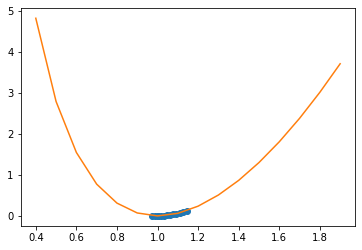

In [43]:
xFit=np.arange(0.4,2,0.1)
plt.plot(lam,EoverV,marker='o')
plt.plot(xFit,func(xFit,popt[0]))

In [44]:
popt

array([4.46083323])